# Import

In [3]:
from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 14})

# Data

In [4]:
n = 10000
X, y = make_regression(n_samples=n, n_features=1, n_informative=1, n_targets=1)
X = X.flatten() + np.random.normal(loc=6, scale=0.5, size=n)
y = y + np.random.normal(loc=300, scale=40, size=n)

Text(0, 0.5, 'Rating')

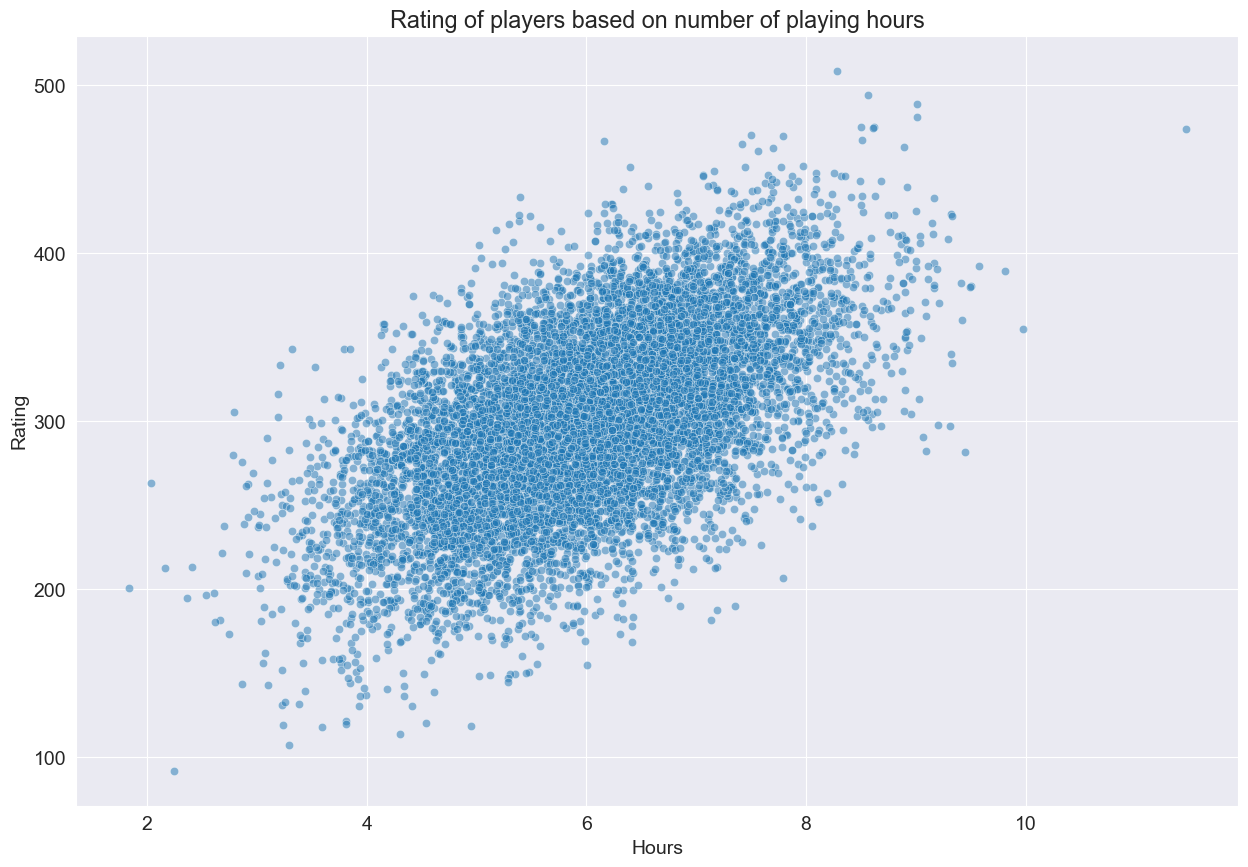

In [5]:
df = pd.DataFrame({'hours': X.flatten(), 'rating': y})
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='hours', y='rating', alpha=0.5)
plt.title('Rating of players based on number of playing hours')
plt.xlabel('Hours')
plt.ylabel('Rating')

In [6]:
df_train, df_test = train_test_split(df, test_size=0.20, shuffle=False)
X_train, y_train = df_train[['hours']], df_train['rating']
X_test, y_test = df_test[['hours']], df_test['rating']

# Model

In [7]:
models = {}
df_pred = df_test.copy()
for alpha in [0.2, 0.5, 0.8]:
    model = LGBMRegressor(objective='quantile', alpha=alpha)
    model.fit(X_train, y_train)
    df_pred[str(alpha)] = model.predict(X_test)

# Predictions Visualisation

Text(0.5, 0, 'Hours')

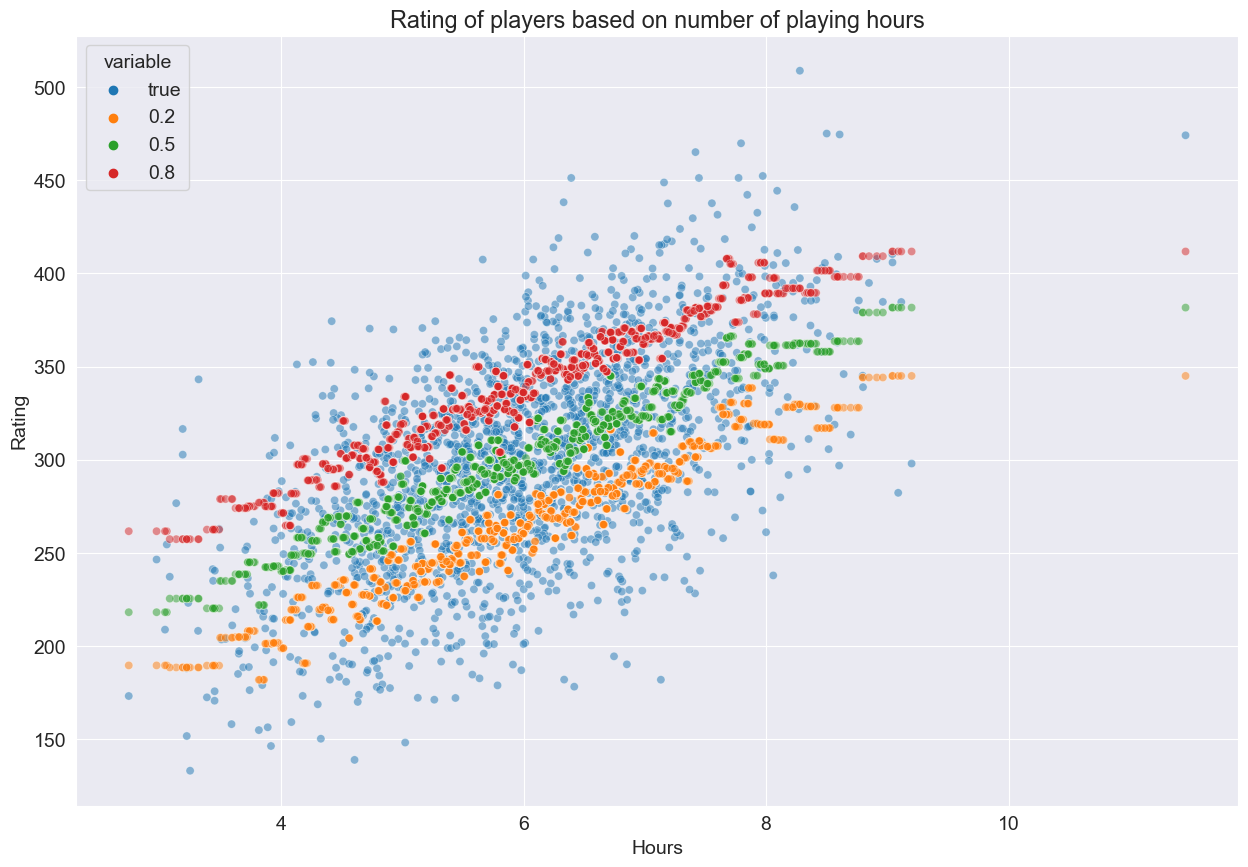

In [8]:
plt.figure(figsize=(15, 10))
df_pred_melted = pd.melt(df_pred.rename(
    columns={'rating': 'true'}), id_vars=['hours'])
sns.scatterplot(data=df_pred_melted, x='hours', y='value',
                hue='variable', hue_order=['true', '0.2', '0.5', '0.8'], alpha=0.5)
plt.title('Rating of players based on number of playing hours')
plt.ylabel('Rating')
plt.xlabel('Hours')

In [9]:
for alpha in [0.2, 0.5, 0.8]:
    statistics = (df_pred[str(alpha)] > df_pred['rating']
                  ).value_counts(normalize=True)
    true_percentage, false_percentage = statistics[True], statistics[False]
    print(
        f"Predictions for alpha = {alpha} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")

Predictions for alpha = 0.2 are greater than true values in 22.400000000000002 % of cases and less or equal in 77.60000000000001 % of cases.
Predictions for alpha = 0.5 are greater than true values in 48.4 % of cases and less or equal in 51.6 % of cases.
Predictions for alpha = 0.8 are greater than true values in 79.7 % of cases and less or equal in 20.3 % of cases.


# Vanilla Quantile regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline

mcycle = pd.read_csv('mcycle.txt',delimiter='\t')

In [2]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [3]:
X, X_cal, y, y_cal = train_test_split(
    mcycle.times, mcycle.accel, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [4]:
model = Sequential()
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [5]:
model.fit(X_train.values, y_train.values, epochs=1000, batch_size=8, verbose=0)
y_pred = model.predict(X_cal.values)

1/1 [==============================] - 0s 82ms/step


In [6]:
def tilted_loss(q, y, f):
    e = (y-f)
    if (e >= 0):
        return K.mean(q*e)
    else:
        return K.mean((1-q)*e)
    return K.mean(val, axis=-1)

In [7]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(1))

    return model

In [20]:
qs = [0.15, 0.85]

# implement the conformal quantile regression using 0.1 and 0.9 quantiles as the intervals
t_test = np.linspace(mcycle.times.min(), mcycle.times.max(), 200)
initial_upper = []
initial_lower = []
models = []

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(X_train.values, y_train.values,
              epochs=500, batch_size=4, verbose=0)
    models.append(model)
    # Predict the quantile
    y_test = model.predict(X_cal.values)
    if (q == 0.15):
        initial_lower = y_test.flatten()
    else:
        initial_upper = y_test.flatten()

1/1 [==============================] - 0s 51ms/step


In [21]:
import scipy.stats as st

In [22]:
sorted_indices = np.argsort(X_cal.values, axis=0)
sorted_x_test = X_cal.values[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]
sorted_y_cal = y_cal.values[sorted_indices]


# sorted_indices_train = np.argsort(X_train.values, axis=0)
# sorted_x_train = X_train.values[sorted_indices_train]
# sorted_y_train = y_train.values[sorted_indices_train]
q95 = st.norm.ppf(0.95)
y_true_sigma = q95 * 0.1 * sorted_x_test

In [23]:
residuals = sorted_y_cal - sorted_y_pred
quantile = np.percentile(residuals, 70)

upper_interval = sorted_y_pred + quantile
lower_interval = sorted_y_pred - quantile

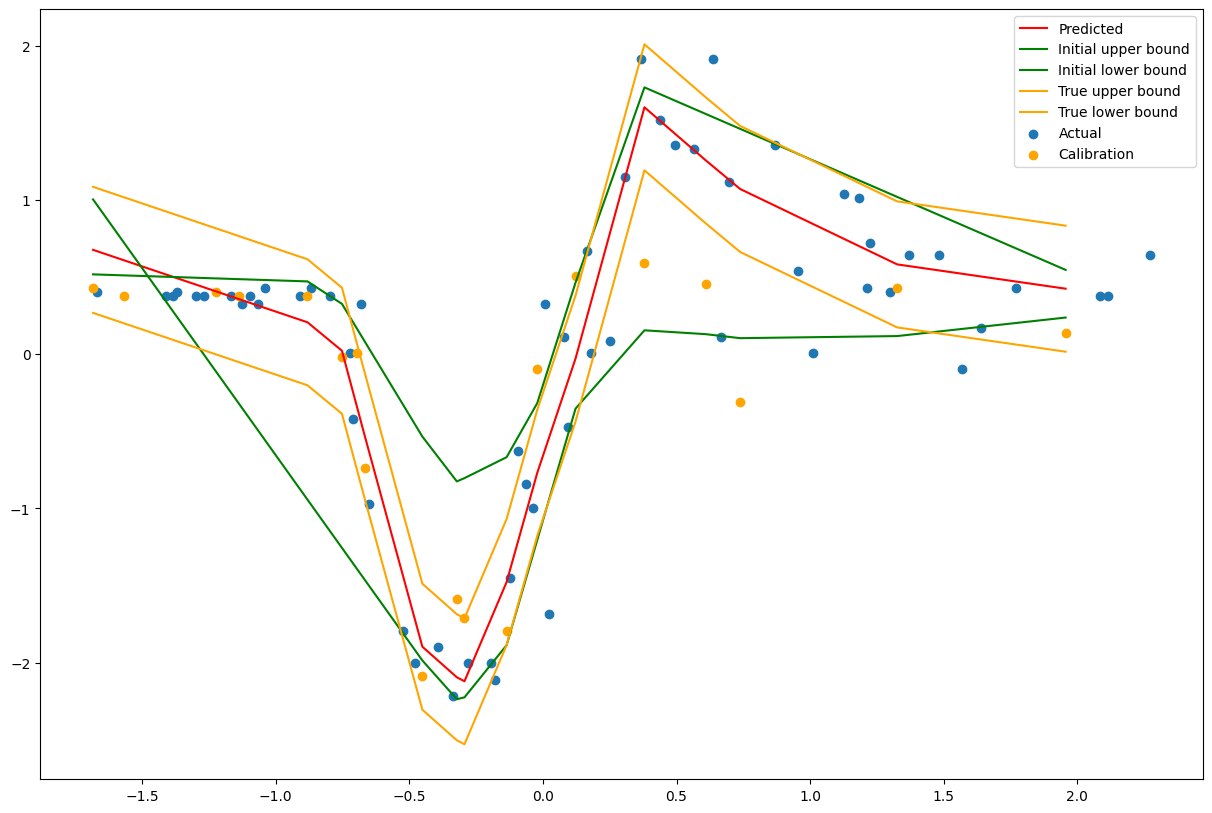

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_x_test, sorted_y_pred, color='red', label='Predicted')
# convert initial_upper and initial_lower to numpy arrays
initial_upper = np.array(initial_upper)
initial_lower = np.array(initial_lower)
plt.plot(sorted_x_test, initial_upper[sorted_indices],
         color='green', label='Initial upper bound')
plt.plot(sorted_x_test, initial_lower[sorted_indices],
         color='green', label='Initial lower bound')
plt.plot(sorted_x_test,
         upper_interval.reshape(-1), color='orange', label='True upper bound')
plt.plot(sorted_x_test,
         lower_interval.reshape(-1), color='orange', label='True lower bound')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()

In [25]:
errors = []
for i in range(len(initial_upper)):
    errors.append(
        max(sorted_y_pred[i] - initial_upper[i], initial_lower[i] - sorted_y_pred[i]))

In [26]:
errors = np.array(errors)
errors = [i[0] for i in errors]
errors = np.array(errors)
errors

array([ 1.4792826 ,  0.28305474, -0.05575693, -0.2538446 ,  0.79622424,
       -0.13993698,  0.4761428 ,  0.6633711 ,  1.7869211 ,  0.20769012,
        2.237128  , -0.5079446 ,  1.007002  ,  0.1830149 ,  1.1137351 ,
        0.74563265,  0.5988452 ,  0.5015711 ,  0.74180746], dtype=float32)

In [27]:
q_hat = np.quantile(errors, 0.70)

In [28]:
q_hat

0.7759876012802124

In [29]:
X_test.values[0]

-0.5947752764711763

In [30]:
qs = [0.15, 0.85]
pred_upper = []
pred_lower = []

y_lower = models[0].predict(X_test.values)
pred_lower.append(y_lower-q_hat)
y_higher = models[1].predict(X_test.values)
pred_upper.append(y_higher+q_hat)

1/1 [==============================] - 0s 23ms/step


In [31]:
sorted_indices_2 = np.argsort(X_test.values, axis=0)
sorted_x_test_2 = X_test.values[sorted_indices_2]
sorted_pred_upper = pred_upper[0][sorted_indices_2]
sorted_pred_lower = pred_lower[0][sorted_indices_2]

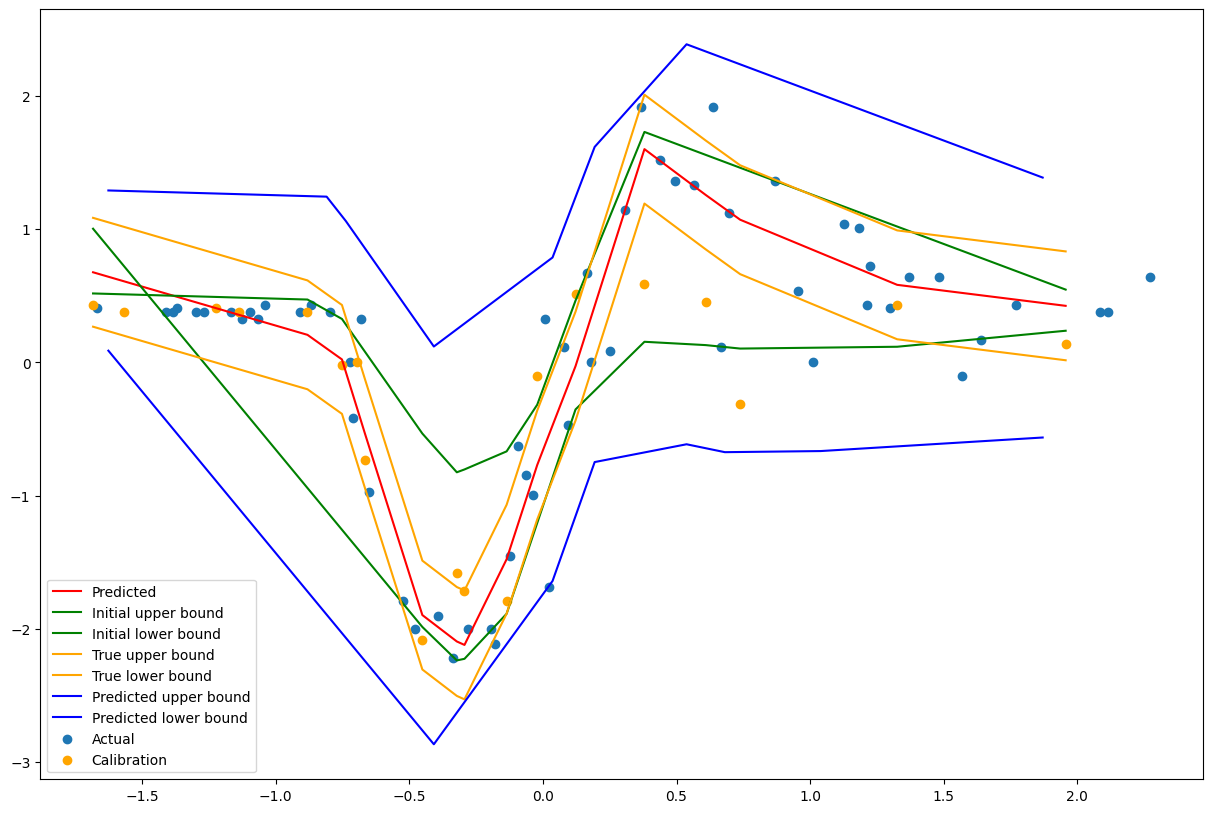

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_x_test, sorted_y_pred, color='red', label='Predicted')
# convert initial_upper and initial_lower to numpy arrays
initial_upper = np.array(initial_upper)
initial_lower = np.array(initial_lower)
plt.plot(sorted_x_test, initial_upper[sorted_indices],
         color='green', label='Initial upper bound')
plt.plot(sorted_x_test, initial_lower[sorted_indices],
         color='green', label='Initial lower bound')
plt.plot(sorted_x_test,
         upper_interval.reshape(-1), color='orange', label='True upper bound')
plt.plot(sorted_x_test,
         lower_interval.reshape(-1), color='orange', label='True lower bound')
plt.plot(sorted_x_test_2, sorted_pred_upper,
         color='blue', label='Predicted upper bound')
plt.plot(sorted_x_test_2, sorted_pred_lower,
         color='blue', label='Predicted lower bound')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()

7/7 [==============================] - 0s 641us/step


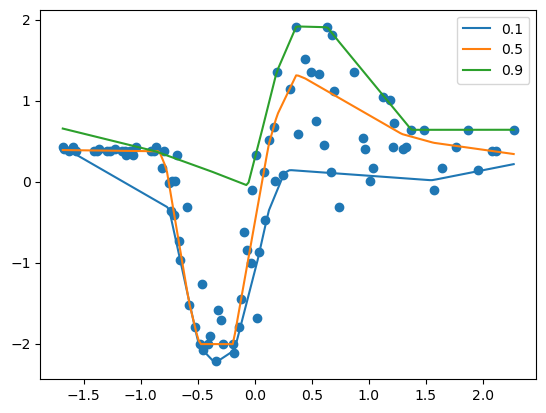

In [6]:
qs = [0.1, 0.5, 0.9]

t_test = np.linspace(mcycle.times.min(), mcycle.times.max(), 200)
plt.scatter(mcycle.times, mcycle.accel)
# implement the conformal quantile regression using 0.1 and 0.9 quantiles as

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(mcycle.times.values, mcycle.accel.values,
              epochs=2000, batch_size=32, verbose=0)

    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q)  # plot out this quantile

plt.legend()
plt.show()

In [23]:
qs = [0.1, 0.9]

# implement the conformal quantile regression using 0.1 and 0.9 quantiles as the intervals
t_test = np.linspace(mcycle.times.min(), mcycle.times.max(), 200)
initial_upper = []
initial_lower = []


for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(X_train.values, y_train.values,
              epochs=500, batch_size=4, verbose=0)

    # Predict the quantile
    y_test = model.predict(X_cal.values)
    if (q == 0.1):
        initial_lower = y_test.flatten()
    else:
        initial_upper = y_test.flatten()

1/1 [==============================] - 0s 31ms/step


In [25]:
initial_lower

array([-2.416774  , -0.2806438 , -0.39167443,  0.14235081,  0.32451436,
       -0.7009679 , -2.3833764 ,  0.14415222,  0.32451436, -1.8819828 ,
        0.13414405, -2.0585475 ,  0.12533703,  0.14735486,  0.32451436,
        0.32451436,  0.32451436, -0.9111295 , -1.2196236 ], dtype=float32)

In [26]:
errors = []
for i in range(len(initial_upper)):
    errors.append(max(y_pred[i] - initial_upper[i],
                  initial_lower[i] - y_pred[i]))

In [27]:
errors

[array([-0.3397436], dtype=float32),
 array([-0.3195365], dtype=float32),
 array([-0.42362332], dtype=float32),
 array([-0.72323596], dtype=float32),
 array([-0.03143707], dtype=float32),
 array([-0.38244453], dtype=float32),
 array([-0.24624133], dtype=float32),
 array([-0.6750194], dtype=float32),
 array([-0.04105106], dtype=float32),
 array([-0.36336052], dtype=float32),
 array([-0.39181936], dtype=float32),
 array([-0.31280553], dtype=float32),
 array([-0.2504366], dtype=float32),
 array([-0.3796345], dtype=float32),
 array([-0.04285359], dtype=float32),
 array([-0.03384086], dtype=float32),
 array([-0.00510144], dtype=float32),
 array([-0.4138985], dtype=float32),
 array([-0.37859762], dtype=float32)]

# Another implementation

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [23]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


In [24]:
mod = smf.quantreg("foodexp ~ income", data)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Wed, 30 Aug 2023   No. Observations:                  235
Time:                        19:12:41   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [25]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["income"]] + res.conf_int().loc[
        "income"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("foodexp ~ income", data).fit()
ols_ci = ols.conf_int().loc["income"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["income"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880097  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033436  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.47538852370587, 'b': 0.4851784236769228, 'lb': 0.45687381301842256, 'ub': 0.5134830343354231}


Text(0, 0.5, 'Food expenditure')

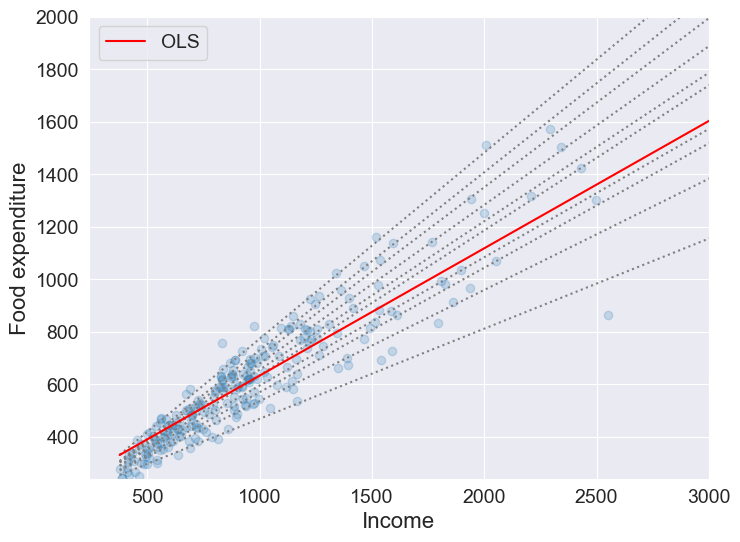

In [26]:
x = np.arange(data.income.min(), data.income.max(), 50)
def get_y(a, b): return a + b * x


fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(data.income, data.foodexp, alpha=0.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel("Income", fontsize=16)
ax.set_ylabel("Food expenditure", fontsize=16)

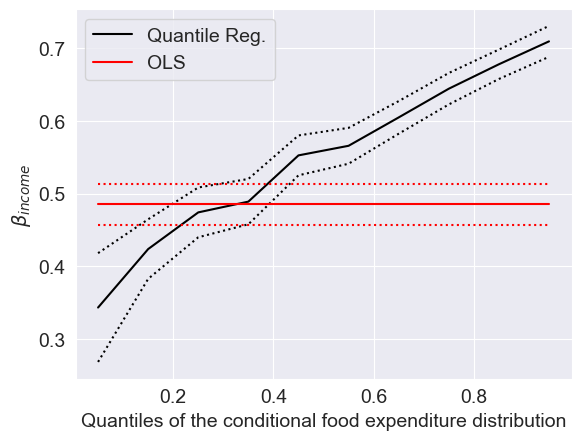

In [27]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{income}$")
plt.xlabel("Quantiles of the conditional food expenditure distribution")
plt.legend()
plt.show()